# Dropout and Regularization in DeepLearning

## Import files

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

In [ ]:
import requests
from pathlib import Path
from google.colab import drive
import os
import random
from PIL import Image
from torchvision import datasets
from numpy.linalg import norm

In [ ]:
!pip install -q torchmetrics
from torchmetrics.classification import MulticlassAccuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 11.1 MB/s eta 0:00:00


In [ ]:
# set device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Download custom data

In [ ]:
drive.mount('/content/gdrive') 
# for this data set must be in mydrive

Mounted at /content/gdrive


In [ ]:
# wlak through data
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
data_path = Path('gdrive/')
PATH = data_path / 'MyDrive/GurNum'
walk_through_dir(PATH)

There are 2 directories and 0 images in 'gdrive/MyDrive/GurNum'.
There are 10 directories and 0 images in 'gdrive/MyDrive/GurNum/train'.
There are 0 directories and 100 images in 'gdrive/MyDrive/GurNum/train/9'.
There are 0 directories and 100 images in 'gdrive/MyDrive/GurNum/train/8'.
There are 0 directories and 100 images in 'gdrive/MyDrive/GurNum/train/3'.
There are 0 directories and 100 images in 'gdrive/MyDrive/GurNum/train/4'.
There are 0 directories and 100 images in 'gdrive/MyDrive/GurNum/train/6'.
There are 0 directories and 100 images in 'gdrive/MyDrive/GurNum/train/0'.
There are 0 directories and 100 images in 'gdrive/MyDrive/GurNum/train/5'.
There are 0 directories and 100 images in 'gdrive/MyDrive/GurNum/train/7'.
There are 0 directories and 100 images in 'gdrive/MyDrive/GurNum/train/1'.
There are 0 directories and 100 images in 'gdrive/MyDrive/GurNum/train/2'.
There are 10 directories and 0 images in 'gdrive/MyDrive/GurNum/val'.
There are 0 directories and 17 images in 'g

In [ ]:
# setup train test path
train_dic = PATH / "train"
test_dic = PATH / "val"

train_dic, test_dic

(PosixPath('gdrive/MyDrive/GurNum/train'),
 PosixPath('gdrive/MyDrive/GurNum/val'))

##Visualize image

Random Image Path: gdrive/MyDrive/GurNum/train/6/16.bmp
Image Class: 6
Imahe height: 32
Imahe width: 32


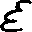

In [ ]:
# set random seed
random.seed(64)

# get all image path list
image_path_list = list(PATH.glob("*/*/*.bmp"))

# get random image path
random_image_path = random.choice(image_path_list)

# get image class from image path
image_class = random_image_path.parent.stem

# open iage
img = Image.open(random_image_path)

# print metadata
print(f"Random Image Path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Imahe height: {img.height}")
print(f"Imahe width: {img.width}")
img

(-0.5, 31.5, 31.5, -0.5)

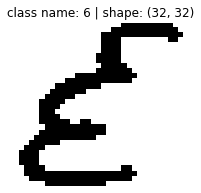

In [ ]:
# turn image into array
img_to_arr = np.asarray(img)

# plot image
plt.figure(figsize=(5,3))
plt.imshow(img_to_arr, cmap = 'gray')
plt.title(f"class name: {image_class} | shape: {img_to_arr.shape}")
plt.axis(False)

## Transforming data

In [ ]:
# writre transform for image
data_transform = transforms.Compose([
    # # # resize image 32x32 --> 64x64
    # transforms.Resize(size=(64, 64)),
    # turn image in to torch tensor
    transforms.Grayscale(),
    transforms.ToTensor() # this conver px 0 to 255 from 0.0 to 1.0
])

# transforms = transforms.Grayscale()

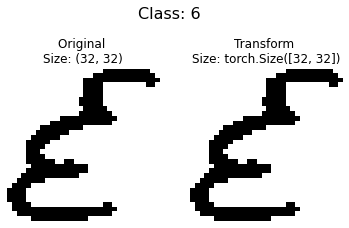

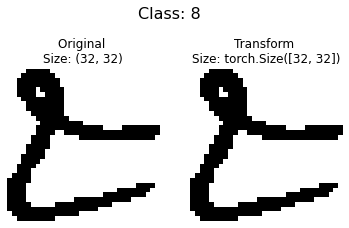

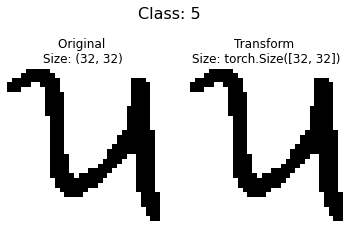

In [ ]:
def plot_transform_image(image_paths, trasform, n=3, seed=64):
  '''
    Plot are in serise of random image

    will oprn n image path from image path anf transform them in to torch tensor

    Args:
      image_paths (list): image path
      trasform (PyTorch transforms): transform the image into given transforms
      n (int, optional): number of random image path
      seed (int, optional): Random seed for random generator | default 64
  '''

  random.seed(seed)
  random_image_path = random.sample(image_paths, k=n)

  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f, cmap = 'gray')
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      transformed_image = trasform(f).permute(1, 2, 0) # [height, width, color channel]
      ax[1].imshow(transformed_image[:,:,0], cmap = 'gray')
      ax[1].set_title(f"Transform \nSize: {transformed_image[:,:,0].shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transform_image(image_path_list, trasform = data_transform, n = 3)

## Load image data using ImageFolder

In [ ]:
train_data = datasets.ImageFolder(root = train_dic, transform = data_transform, target_transform = None)
test_data = datasets.ImageFolder(root = test_dic, transform = data_transform)

print(f"Train Data: {train_data} \nTest Data: {test_data}")

Train Data: Dataset ImageFolder
    Number of datapoints: 1000
    Root location: gdrive/MyDrive/GurNum/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           ) 
Test Data: Dataset ImageFolder
    Number of datapoints: 178
    Root location: gdrive/MyDrive/GurNum/val
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )


In [ ]:
# class name
class_names = train_data.classes
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
# inx
class_to_idx = train_data.class_to_idx
class_to_idx

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"image tensor:\n{img}")
print(f"image shape: {img.shape}")
print(f"image type: {type(img)}")
print(f"image label: {label}")
print(f"image label type: {type(label)}")

image tensor:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 0.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
image shape: torch.Size([1, 32, 32])
image type: <class 'torch.Tensor'>
image label: 0
image label type: <class 'int'>


Original image shape: torch.Size([1, 32, 32]) --> [color_channel, height, width]
Permuted image shape: torch.Size([32, 32, 1]) --> [height, width, color_channel]


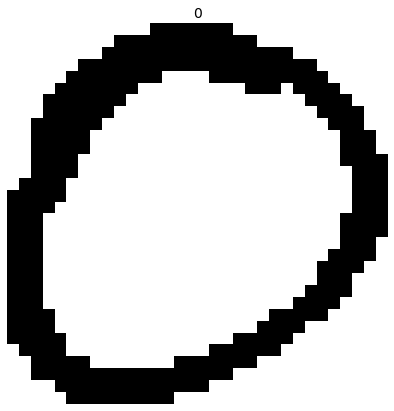

In [ ]:
# permute the image
per_img = img.permute(1,2,0)

# print different shape
print(f"Original image shape: {img.shape} --> [color_channel, height, width]")
print(f"Permuted image shape: {per_img.shape} --> [height, width, color_channel]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(per_img.squeeze(), cmap = 'gray')
plt.axis("off")
plt.title(class_names[label], fontsize=14);

## DataLoader

In [ ]:
# setup data loader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data, 
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data, 
                             batch_size = BATCH_SIZE,
                             shuffle = False)

In [ ]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 1, 32, 32]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## Create Dropout Class

In [ ]:
class Dropout(nn.Module):
  def __init__(self, probs: float = 0):
    super().__init__()
    self.probs = probs
    if self.probs < 0 or self.probs > 1:
      raise ValueError("prob must be probability (between 0 t0 1).")

  def forward(self, x):
    if self.training:
      drop_mat = (torch.empty(x.size()[1]).uniform_(0, 1) >= self.probs)
      drop_mat = drop_mat.type(torch.float)
      # print(drop_mat)
      x = x.mul(drop_mat)
      
    return x
  

## Create Model

In [ ]:
class GurNumModel(nn.Module):
  def __init__(self, input_units: int, hidden_units: int, output_units: int, number_hidden_layers: int, probs: float = 0):
    super().__init__()

    # self.dropout = Dropout(probs)
    layers = []

    for i in range(number_hidden_layers):
      if i == 0:
        layers.append(nn.Flatten())
        layers.append(nn.Linear(in_features = input_units, out_features = hidden_units))
        layers.append(nn.Tanh())
        layers.append(Dropout(probs))

      else:
        layers.append(nn.Linear(in_features = hidden_units, out_features = hidden_units))
        layers.append(nn.Tanh())
        layers.append(Dropout(probs))

    layers.append(nn.Linear(in_features = hidden_units, out_features = output_units))
    layers.append(nn.Tanh())

    self.layer = nn.Sequential(*layers)

  def forward(self, x):
    return self.layer(x)

In [ ]:
# gurnum_model = GurNumModel(input_units = 1024, hidden_units = 14, output_units = len(class_names), number_hidden_layers = 4).to(device)
# gurnum_model

## Dropout Function

In [ ]:
def dropout(model: torch.nn.Module, probability: float):
  for para in model.state_dict():
    # print(f"para: \n{para}")
    # print()
    model_param = model.state_dict()
    if para.split('.')[-1] == 'weight':
      # print(f"gurnum_model.state_dict()[para]: \n{model_param[para]}")
      # print(model_param[para].shape)
      drop_mat = (torch.empty(model_param[para].size()[1]).uniform_(0, 1) >= probability)
      drop_mat = drop_mat.type(torch.float)
      # print(drop_mat)
      model_param[para] = model_param[para].mul(drop_mat)
    #   print(f"gurnum_model.state_dict()[para]: \n{model_param[para]}")
    # print("=====================================================================")
    model.load_state_dict(model_param)
    model_param = model.state_dict()
    # if para.split('.')[-1] == 'weight':
    #   print("=====================================================================")
    #   print(f"gurnum_model.state_dict()[para]: \n{model_param[para]}")
    #   print("=====================================================================")

## Train and Test Loop (Function)

In [ ]:
# train loop
def train_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
               accuracy_fn, L1_regularization: bool, L2_regularization: bool,
               regularization_lambda: float, device: torch.device = device):
  
  train_loss, train_acc = 0, 0

  for batch, (x_train, y_train) in enumerate(dataloader):

    if device == 'cuda':
      x_train, y_train = x_train.to(device), y_train.to(device) 

    # train
    model.train()

    # 1.Forward
    # x_train = transforms(x_train).to(device)
    y_pred = model(x_train)

    # print(f"\ny_pred: {y_pred.shape} y_train:{y_train.shape}\n{torch.argmax(y_pred, dim = 1)}\n")
    # 2. Loss and accuracy
    loss = loss_fn(y_pred, y_train)

    # code for Regularization
    # L1_regularization = True
    l1 = 0
    if L1_regularization:
      for para in model.parameters():
        l1 += para.abs().sum()
      loss += regularization_lambda * l1

    # L2_regularization = True
    l2 = 0
    if L2_regularization:
      for para in model.parameters():
        l2 += para.pow(2).sum()
      loss += regularization_lambda * l2

    # if Dropout:
    #   dropout(model, prob)
      

    train_loss += loss
    acc = accuracy_fn(y_train, torch.argmax(y_pred, dim = 1))
    train_acc += acc

    # 3. zero grad
    optimizer.zero_grad()

    # 4. backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  print(f"Train Loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f}")

  return train_loss



# test loop
def test_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, accuracy_fn,
              device: torch.device = device):
  
  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for x_test, y_test in dataloader:

      if device == 'cuda':
        x_test, y_test = x_test.to(device), y_test.to(device) 

      # x_test = transforms(x_test).to(device)

      # 1. Forward
      test_pred = model(x_test)

      # 2. Loss and Accuracy
      loss = loss_fn(test_pred, y_test)

      # code for Regularization
      # L1_regularization = True
      # l1 = 0
      # if L1_regularization:
      #   for para in model.parameters():
      #     l1 += para.abs().sum()
      #   loss += regularization_lambda * l1

      # # L2_regularization = True
      # l2 = 0
      # if L2_regularization:
      #   for para in model.parameters():
      #     l2 += para.pow(2).sum()
      #   loss += regularization_lambda * l2

      test_loss += loss

      test_acc += accuracy_fn(y_test, torch.argmax(test_pred, dim = 1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

  return test_loss

## Validate function

In [ ]:
# check gradient
def valid_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
               accuracy_fn, device: torch.device = device):
  
  val_loss = 0

  for batch, (x_val, y_val) in enumerate(dataloader):

    x_val, y_val = x_val.to(device), y_val.to(device)

    model.train()

    val_pred = model(x_val)

    loss = loss_fn(val_pred, y_val)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    val_loss += loss

  val_loss /= len(dataloader)

  return val_loss

  # train_loss, train_acc = 0, 0

  # for batch, (x_train, y_train) in enumerate(dataloader):

  #   if device == 'cuda':
  #     x_train, y_train = x_train.to(device), y_train.to(device) 

  #   # train
  #   model.train()

  #   # 1.Forward
  #   # x_train = transforms(x_train).to(device)
  #   y_pred = model(x_train)

  #   # print(f"\ny_pred: {y_pred.shape} y_train:{y_train.shape}\n{torch.argmax(y_pred, dim = 1)}\n")
  #   # 2. Loss and accuracy
  #   loss = loss_fn(y_pred, y_train)

  #   # code for Regularization
  #   # L1_regularization = True
  #   l1 = 0
  #   if L1_regularization:
  #     for para in model.parameters():
  #       l1 += para.abs().sum()
  #     loss += regularization_lambda * l1

  #   # L2_regularization = True
  #   l2 = 0
  #   if L2_regularization:
  #     for para in model.parameters():
  #       l2 += para.pow(2).sum()
  #     loss += regularization_lambda * l2

  #   # if Dropout:
  #   #   dropout(model, prob)
      

  #   train_loss += loss
  #   acc = accuracy_fn(y_train, torch.argmax(y_pred, dim = 1))
  #   train_acc += acc

  #   # 3. zero grad
  #   optimizer.zero_grad()

  #   # 4. backward
  #   loss.backward()

  #   # 5. optimizer step
  #   optimizer.step()

  # train_loss /= len(dataloader)
  # train_acc /= len(dataloader)


## Train model without any Regularization 

In [ ]:
torch.manual_seed(32)
torch.cuda.manual_seed(32)

gurnum_model = GurNumModel(input_units = 1024, hidden_units = 13,
                           output_units = len(class_names),
                           number_hidden_layers = 3, probs = 0).to(device)
gurnum_model


# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(params = gurnum_model.parameters(), lr = 0.003)

# accuracy function
accuracy_fn = MulticlassAccuracy(num_classes = len(class_names)).to(device)


# train model
epoches = 25

torch.manual_seed(64)
torch.cuda.manual_seed(64)

regularization_lambda = 0

for epoch in tqdm(range(epoches)):

  print(f"Epoch: {epoch+1} --------------------------")

  train_loss = train_loop(model = gurnum_model, dataloader = train_dataloader,
                          loss_fn = loss_fn, optimizer = optimizer,
                          accuracy_fn = accuracy_fn, L1_regularization = False, 
                          L2_regularization = False, regularization_lambda = regularization_lambda,
                          device = device)
  
  test_loss = test_loop(model = gurnum_model, dataloader = test_dataloader,
                        loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                        device = device)
  
  print("\n")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 --------------------------
Train Loss: 2.2017 Train Accuracy: 0.1826
Test Loss: 2.0562 Test Accuracy: 0.1678


Epoch: 2 --------------------------
Train Loss: 1.8424 Train Accuracy: 0.4104
Test Loss: 1.7920 Test Accuracy: 0.1489


Epoch: 3 --------------------------
Train Loss: 1.6595 Train Accuracy: 0.5006
Test Loss: 1.7237 Test Accuracy: 0.1778


Epoch: 4 --------------------------
Train Loss: 1.5836 Train Accuracy: 0.5176
Test Loss: 1.5913 Test Accuracy: 0.1947


Epoch: 5 --------------------------
Train Loss: 1.4878 Train Accuracy: 0.5567
Test Loss: 1.5183 Test Accuracy: 0.1932


Epoch: 6 --------------------------
Train Loss: 1.3864 Train Accuracy: 0.6362
Test Loss: 1.4010 Test Accuracy: 0.1899


Epoch: 7 --------------------------
Train Loss: 1.2984 Train Accuracy: 0.6372
Test Loss: 1.3261 Test Accuracy: 0.1897


Epoch: 8 --------------------------
Train Loss: 1.2383 Train Accuracy: 0.6339
Test Loss: 1.3073 Test Accuracy: 0.1901


Epoch: 9 --------------------------
Trai

## Train model with L1 Regularization

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)

gurnum_model = GurNumModel(input_units = 1024, hidden_units = 13,
                           output_units = len(class_names), 
                           number_hidden_layers = 3, probs = 0).to(device)
gurnum_model


# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(params = gurnum_model.parameters(), lr = 0.0033)

# accuracy function
accuracy_fn = MulticlassAccuracy(num_classes = len(class_names)).to(device)


# train model
epoches = 25

torch.manual_seed(64)
torch.cuda.manual_seed(64)

regularization_lambda = 0.0018

for epoch in tqdm(range(epoches)):

  print(f"Epoch: {epoch+1} --------------------------")

  train_loss = train_loop(model = gurnum_model, dataloader = train_dataloader,
                          loss_fn = loss_fn, optimizer = optimizer,
                          accuracy_fn = accuracy_fn, L1_regularization = True, 
                          L2_regularization = False, regularization_lambda = regularization_lambda,
                          device = device)
  
  test_loss = test_loop(model = gurnum_model, dataloader = test_dataloader,
                        loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                        device = device)
  
  print("\n")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 --------------------------
Train Loss: 2.4896 Train Accuracy: 0.1872
Test Loss: 2.0296 Test Accuracy: 0.1386


Epoch: 2 --------------------------
Train Loss: 2.1226 Train Accuracy: 0.5887
Test Loss: 1.7548 Test Accuracy: 0.1642


Epoch: 3 --------------------------
Train Loss: 1.8969 Train Accuracy: 0.6549
Test Loss: 1.5532 Test Accuracy: 0.2161


Epoch: 4 --------------------------
Train Loss: 1.7417 Train Accuracy: 0.7314
Test Loss: 1.4731 Test Accuracy: 0.2185


Epoch: 5 --------------------------
Train Loss: 1.6836 Train Accuracy: 0.6695
Test Loss: 1.3426 Test Accuracy: 0.1564


Epoch: 6 --------------------------
Train Loss: 1.6642 Train Accuracy: 0.6604
Test Loss: 1.3689 Test Accuracy: 0.2040


Epoch: 7 --------------------------
Train Loss: 1.6037 Train Accuracy: 0.5834
Test Loss: 1.3450 Test Accuracy: 0.1661


Epoch: 8 --------------------------
Train Loss: 1.6077 Train Accuracy: 0.5414
Test Loss: 1.2779 Test Accuracy: 0.1417


Epoch: 9 --------------------------
Trai

## Train Model with L2 Regularization

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)

gurnum_model = GurNumModel(input_units = 1024, hidden_units = 13, 
                           output_units = len(class_names), 
                           number_hidden_layers = 3, probs = 0).to(device)
gurnum_model


# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(params = gurnum_model.parameters(), lr = 0.0033)

# accuracy function
accuracy_fn = MulticlassAccuracy(num_classes = len(class_names)).to(device)


# train model
epoches = 25

torch.manual_seed(64)
torch.cuda.manual_seed(64)

regularization_lambda = 0.0019

for epoch in tqdm(range(epoches)):

  print(f"Epoch: {epoch+1} --------------------------")

  train_loss = train_loop(model = gurnum_model, dataloader = train_dataloader,
                          loss_fn = loss_fn, optimizer = optimizer,
                          accuracy_fn = accuracy_fn, L1_regularization = False, 
                          L2_regularization = True, regularization_lambda = regularization_lambda,
                          device = device)
  
  test_loss = test_loop(model = gurnum_model, dataloader = test_dataloader,
                        loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                        device = device)
  
  print("\n")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 --------------------------
Train Loss: 2.1776 Train Accuracy: 0.2233
Test Loss: 1.9638 Test Accuracy: 0.1788


Epoch: 2 --------------------------
Train Loss: 1.8236 Train Accuracy: 0.6936
Test Loss: 1.6508 Test Accuracy: 0.2276


Epoch: 3 --------------------------
Train Loss: 1.5890 Train Accuracy: 0.7368
Test Loss: 1.5034 Test Accuracy: 0.2289


Epoch: 4 --------------------------
Train Loss: 1.4309 Train Accuracy: 0.7779
Test Loss: 1.3363 Test Accuracy: 0.2204


Epoch: 5 --------------------------
Train Loss: 1.3232 Train Accuracy: 0.8433
Test Loss: 1.2481 Test Accuracy: 0.2346


Epoch: 6 --------------------------
Train Loss: 1.2555 Train Accuracy: 0.8025
Test Loss: 1.3203 Test Accuracy: 0.1840


Epoch: 7 --------------------------
Train Loss: 1.2350 Train Accuracy: 0.7541
Test Loss: 1.1415 Test Accuracy: 0.2080


Epoch: 8 --------------------------
Train Loss: 1.2388 Train Accuracy: 0.7726
Test Loss: 1.1351 Test Accuracy: 0.1952


Epoch: 9 --------------------------
Trai

## Train model with Dropout

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)

gurnum_model = GurNumModel(input_units = 1024, hidden_units = 13, 
                           output_units = len(class_names), 
                           number_hidden_layers = 3, probs = 0.25).to(device)
print(gurnum_model)


# D = (torch.empty(A.size()).uniform_(0, 1) >= p)
# x = A.mul(D)

# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(params = gurnum_model.parameters(), lr = 0.0014)

# accuracy function
accuracy_fn = MulticlassAccuracy(num_classes = len(class_names)).to(device)


# train model
epoches = 25

torch.manual_seed(64)
torch.cuda.manual_seed(64)

regularization_lambda = 0

for epoch in tqdm(range(epoches)):

  print(f"Epoch: {epoch+1} --------------------------")

  train_loss = train_loop(model = gurnum_model, dataloader = train_dataloader,
                          loss_fn = loss_fn, optimizer = optimizer,
                          accuracy_fn = accuracy_fn, L1_regularization = False, 
                          L2_regularization = True, regularization_lambda = regularization_lambda,
                          device = device)
  
  test_loss = test_loop(model = gurnum_model, dataloader = test_dataloader,
                        loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                        device = device)
  
  print("\n")

GurNumModel(
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=13, bias=True)
    (2): Tanh()
    (3): Dropout()
    (4): Linear(in_features=13, out_features=13, bias=True)
    (5): Tanh()
    (6): Dropout()
    (7): Linear(in_features=13, out_features=13, bias=True)
    (8): Tanh()
    (9): Dropout()
    (10): Linear(in_features=13, out_features=10, bias=True)
    (11): Tanh()
  )
)


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 --------------------------
Train Loss: 2.2823 Train Accuracy: 0.0407
Test Loss: 2.2081 Test Accuracy: 0.0737


Epoch: 2 --------------------------
Train Loss: 2.1994 Train Accuracy: 0.1284
Test Loss: 2.0844 Test Accuracy: 0.1240


Epoch: 3 --------------------------
Train Loss: 2.1210 Train Accuracy: 0.1829
Test Loss: 1.9570 Test Accuracy: 0.1537


Epoch: 4 --------------------------
Train Loss: 2.0008 Train Accuracy: 0.2978
Test Loss: 1.8589 Test Accuracy: 0.1619


Epoch: 5 --------------------------
Train Loss: 1.9351 Train Accuracy: 0.3012
Test Loss: 1.7922 Test Accuracy: 0.1835


Epoch: 6 --------------------------
Train Loss: 1.8429 Train Accuracy: 0.4607
Test Loss: 1.7532 Test Accuracy: 0.2122


Epoch: 7 --------------------------
Train Loss: 1.7838 Train Accuracy: 0.4364
Test Loss: 1.6894 Test Accuracy: 0.2174


Epoch: 8 --------------------------
Train Loss: 1.7557 Train Accuracy: 0.4382
Test Loss: 1.6762 Test Accuracy: 0.1882


Epoch: 9 --------------------------
Trai

## checking gradient

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)

gurnum_model = GurNumModel(input_units = 1024, hidden_units = 13, 
                           output_units = len(class_names), 
                           number_hidden_layers = 3, probs = 0).to(device)
print(gurnum_model)

# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(params = gurnum_model.parameters(), lr = 0.003)

# accuracy function
accuracy_fn = MulticlassAccuracy(num_classes = len(class_names)).to(device)


# train model
epoches = 5

approx_ls = []
actual_ls = []

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  # print(f"Epoch: {epoch+1} --------------------------")

  # approx grad -- J approx theta
  param_state = gurnum_model.state_dict()
  # print(param_state)
  for param in gurnum_model.state_dict():
    # print(param)
    if param.split('.')[-1] == 'weight':
      s,t = param_state[param].size()
      param_state[param] = param_state[param].reshape(s*t,)

    # append in list
    for i in param_state[param]:
      approx_ls.append(i.item())

  val_loss = valid_loop(model = gurnum_model, dataloader = train_dataloader,
                        loss_fn = loss_fn, optimizer = optimizer,
                        accuracy_fn = accuracy_fn, device = device)
  

  # actual grad -- J actual theta
  param_state = gurnum_model.state_dict()
  # print(param_state)
  for param in gurnum_model.state_dict():
    # print(param)
    if param.split('.')[-1] == 'weight':
      s,t = param_state[param].size()
      param_state[param] = param_state[param].reshape(s*t,)

    for i in param_state[param]:
      actual_ls.append(i.item())

  # print("\n")

GurNumModel(
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=13, bias=True)
    (2): Tanh()
    (3): Dropout()
    (4): Linear(in_features=13, out_features=13, bias=True)
    (5): Tanh()
    (6): Dropout()
    (7): Linear(in_features=13, out_features=13, bias=True)
    (8): Tanh()
    (9): Dropout()
    (10): Linear(in_features=13, out_features=10, bias=True)
    (11): Tanh()
  )
)


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# param_state = gurnum_model.state_dict()
# # print(param_state)
# lst = []
# for param in gurnum_model.state_dict():
#   # print(param)
#   if param.split('.')[-1] == 'weight':
#     s,t = param_state[param].size()
#     param_state[param] = param_state[param].reshape(s*t,)

#   # if param.split('.')[-1] == 'bias':
#   #   print(param_state[param])
#   #   # s = param_state[param].size()
#   #   # param_state[param] = param_state[param].reshape(s,)

#   print(param_state[param][0])
#   for i in param_state[param]:
#     # print(type(i.item()))
#     lst.append(i.item())
#   # print(s,t)
#   break

# lst

In [ ]:
len(approx_ls), len(actual_ls)
print(approx_ls[0])
# approx_ls -= 1e-7
print(norm(approx_ls))

-0.028173670172691345
13.509067353844285


In [ ]:
# # approx_grad = torch.tensor(approx_ls).type(torch.float)
# # actual_grad = torch.tensor(actual_ls).type(torch.float)
# approx_grad = torch.FloatTensor(approx_ls)
# actual_grad = torch.FloatTensor(actual_ls)

# approx_grad, actual_grad

In [ ]:
actual_grad = actual_ls   # J theta actual
plus_cost = []
minus_cost = []
epsilon = 1e-7
for i in range(len(approx_ls)):
  plus_cost.append(approx_ls[i] + epsilon)
  minus_cost.append(approx_ls[i] - epsilon)

# calcualete approc gradient

approx_grad = []  # J theta approx

for i, j in zip(plus_cost, minus_cost):
  approx_grad.append((i - j) / 2 * epsilon)

# approx_grad = cost_diff / (2 * epsilon)

numerator = []
for i in range(len(actual_grad)):
  numerator.append(actual_grad[i] - approx_grad[i])

num = norm(numerator)
dnum = norm(actual_grad) + norm(approx_grad)

diff = num / dnum

diff

0.9999999999998279

For correct gradient we need to make our difference less of equal than 1e-5 or 1e-7 but here we get 1e-1.

Hence, our gradient is not proper.